In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import scipy
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["svg.fonttype"] = "none"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start(

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.





Summary of the MLMR
                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               Spike_Nb  
No. Observations:               2976                  Method:                           REML      
No. Groups:                     96                    Scale:                            38.3247   
Min. group size:                31                    Log-Likelihood:                   -9856.9423
Max. group size:                31                    Converged:                        Yes       
Mean group size:                31.0                                                              
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept          

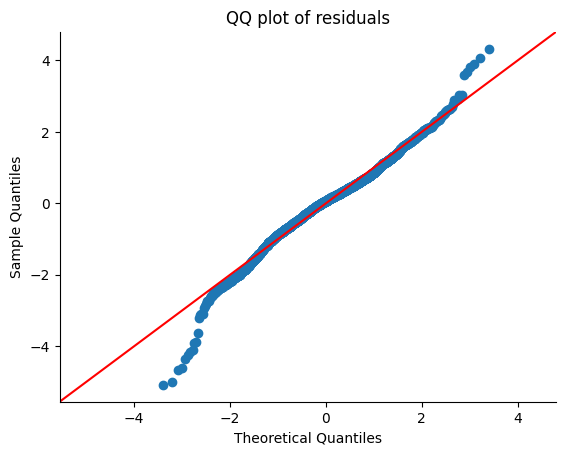



Pairwise Analyses for each injected current

Estimated marginal means at Injected_Current = 0:
  SHAM_Male: -2.2725
  LNIO_Male: -2.8493
  SHAM_Female: -2.1935
  LNIO_Female: -1.4587

Pairwise comparisons (adjusted for multiple testing):
Group1 vs Group2 | Mean Diff | SE Diff | t-stat | p-value | p-value_adj | Significant
SHAM_Male vs LNIO_Male | 0.5768 | 2.5330 | 0.228 | 0.8199 | 0.9794 | False
SHAM_Male vs SHAM_Female | -0.0791 | 3.0589 | -0.026 | 0.9794 | 0.9794 | False
SHAM_Male vs LNIO_Female | -0.8138 | 2.7948 | -0.291 | 0.7709 | 0.9794 | False
LNIO_Male vs SHAM_Female | -0.6558 | 2.6866 | -0.244 | 0.8072 | 0.9794 | False
LNIO_Male vs LNIO_Female | -1.3906 | 2.3816 | -0.584 | 0.5593 | 0.9794 | False
SHAM_Female vs LNIO_Female | -0.7348 | 2.9347 | -0.250 | 0.8023 | 0.9794 | False

Estimated marginal means at Injected_Current = 10:
  SHAM_Male: -1.6780
  LNIO_Male: -1.9038
  SHAM_Female: -1.1638
  LNIO_Female: 0.0207

Pairwise comparisons (adjusted for multiple testing):
Group1 v

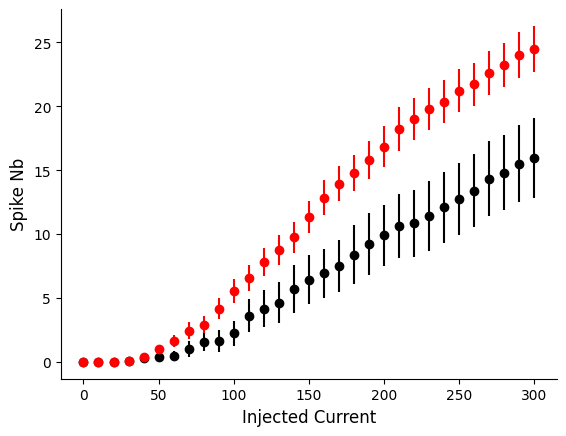



IO curve figure for Females


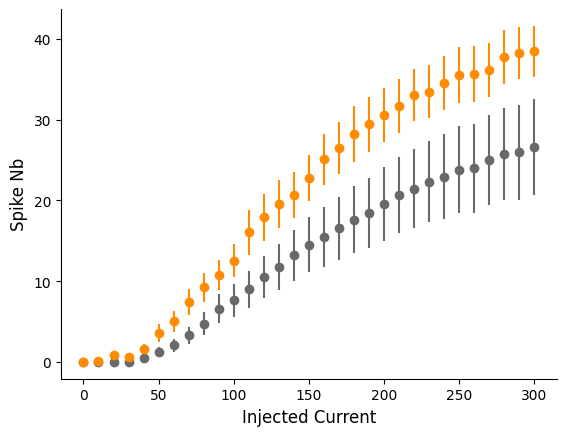

In [2]:

df_taken=pd.read_csv('IOcurve_dataframe.csv')

list_categories_order=["SHAM_Male","LNIO_Male","SHAM_Female","LNIO_Female"]

#perform MLMR
df_taken["Animal_Condition_Sex"] = pd.Categorical(df_taken["Animal_Condition_Sex"], categories=list_categories_order)
model = mixedlm(
    "Spike_Nb ~ C(Animal_Condition_Sex) * Injected_Current",  # fixed effects
    data=df_taken,
    groups=df_taken["Cell_Name"],         # random intercepts per patient
    vc_formula={"Animal_Name": "0 + C(Animal_Name)"}
)
result = model.fit()
print()
print()
print('Summary of the MLMR')
print(result.summary())

# Add residuals and fitted values to your dataframe
df_taken["residuals"] = result.resid
df_taken["fitted"] = result.fittedvalues

# QQ plot of residuals
sm.qqplot(df_taken["residuals"], line="45", fit = True)
plt.title("QQ plot of residuals")
plt.show()




# === Define parameters for estimated marginal means calculation ===
categories = df_taken["Animal_Condition_Sex"].cat.categories.tolist()
intercept = result.params["Intercept"]
inj_cur_coef = result.params.get("Injected_Current", 0)

# Function to get coefficient or 0 if not present (e.g., reference category)
def get_coef(name):
    return result.params.get(name, 0)

print()
print()
print('Pairwise Analyses for each injected current')
list_inj_cur=[]
for i in range(31):
    list_inj_cur.append(i*10)
for inj_cur in list_inj_cur:
    
    # === Calculate estimated marginal means for each group at time inj_cur ===
    marginal_means = {}
    for cat in categories:
        cond_coef = get_coef(f"C(Animal_Condition_Sex)[T.{cat}]")
        interaction_coef = get_coef(f"C(Animal_Condition_Sex)[T.{cat}]:Injected_Current")
        mean = intercept + cond_coef + inj_cur_coef * inj_cur + interaction_coef * inj_cur
        marginal_means[cat] = mean
    
    print(f"\nEstimated marginal means at Injected_Current = {inj_cur}:")
    for k, v in marginal_means.items():
        print(f"  {k}: {v:.4f}")
    
    # === Prepare covariance matrix for contrasts ===
    cov = result.cov_params()
    
    # Degrees of freedom approximation:
    df_resid = result.df_resid if hasattr(result, "df_resid") else result.nobs - len(result.params)
    
    # === Compute pairwise contrasts ===
    alpha = 0.05
    pairwise_results = []
    
    for cat1, cat2 in combinations(categories, 2):
        
        # Difference in marginal means
        diff = marginal_means[cat1] - marginal_means[cat2]
        
        #compute manually var of marginal_means_diff
        if cat1==list_categories_order[0]:
            param_name_cat2 = "C(Animal_Condition_Sex)[T."+cat2+"]"
            param_name_cat2_IC = "C(Animal_Condition_Sex)[T."+cat2+"]:Injected_Current"
            list_var_diff=[
            cov[param_name_cat2][param_name_cat2],
            inj_cur*inj_cur*cov[param_name_cat2_IC][param_name_cat2_IC],
            2*inj_cur*cov[param_name_cat2][param_name_cat2_IC],
            ]
            var_diff=np.sum(list_var_diff)
            
        elif cat2==list_categories_order[0]:
            param_name_cat1 = "C(Animal_Condition_Sex)[T."+cat1+"]"
            param_name_cat1_IC = "C(Animal_Condition_Sex)[T."+cat1+"]:Injected_Current"
            list_var_diff=[
            cov[param_name_cat1][param_name_cat1],
            inj_cur*inj_cur*cov[param_name_cat1_IC][param_name_cat1_IC],
            2*inj_cur*cov[param_name_cat1][param_name_cat1_IC],
            ]
            var_diff=np.sum(list_var_diff)
        
        else:
            param_name_cat1 = "C(Animal_Condition_Sex)[T."+cat1+"]"
            param_name_cat2 = "C(Animal_Condition_Sex)[T."+cat2+"]"
            param_name_cat1_IC = "C(Animal_Condition_Sex)[T."+cat1+"]:Injected_Current"
            param_name_cat2_IC = "C(Animal_Condition_Sex)[T."+cat2+"]:Injected_Current"
            list_var_diff=[
            cov[param_name_cat1][param_name_cat1],
            cov[param_name_cat2][param_name_cat2],
            inj_cur*inj_cur*cov[param_name_cat1_IC][param_name_cat1_IC],
            inj_cur*inj_cur*cov[param_name_cat2_IC][param_name_cat2_IC],
            -2*cov[param_name_cat1][param_name_cat2],
            2*inj_cur*cov[param_name_cat1][param_name_cat1_IC],
            -2*inj_cur*cov[param_name_cat1][param_name_cat2_IC],
            -2*inj_cur*cov[param_name_cat2][param_name_cat1_IC],
            2*inj_cur*cov[param_name_cat2][param_name_cat2_IC],
            -2*inj_cur*inj_cur*cov[param_name_cat1_IC][param_name_cat2_IC],
            ]
            var_diff=np.sum(list_var_diff)
        

        
        se_diff = np.sqrt(var_diff)
        t_stat = diff / se_diff
        pval = 2 * scipy.stats.t.sf(np.abs(t_stat), df=df_resid)  # two-sided p-value
    
        pairwise_results.append((cat1, cat2, diff, se_diff, t_stat, pval))
    
    # === Multiple testing correction (Benjamini-Hochberg FDR) ===
    pvals = [x[5] for x in pairwise_results]
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    
    # === Print results ===
    print("\nPairwise comparisons (adjusted for multiple testing):")
    print("Group1 vs Group2 | Mean Diff | SE Diff | t-stat | p-value | p-value_adj | Significant")
    for i, (cat1, cat2, diff, se_diff, t_stat, pval) in enumerate(pairwise_results):
        print(f"{cat1} vs {cat2} | {diff:.4f} | {se_diff:.4f} | {t_stat:.3f} | {pval:.4g} | {pvals_corrected[i]:.4g} | {reject[i]}")



# build figures
print()
print()
print('IO curve figure for Males')
fig = plt.figure()

list_inj_cur=[]
for i in range(31):
    list_inj_cur.append(i*10)

list_animal_condition=["SHAM_Male","LNIO_Male"]
for animal_condition in list_animal_condition:
    for inj_cur in list_inj_cur:
        df_trans = df_taken.loc[df_taken["Animal_Condition_Sex"]==animal_condition]
        df_trans = df_trans.loc[df_trans["Injected_Current"]==inj_cur]
        if animal_condition=="SHAM_Male":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="k")
        elif animal_condition=="LNIO_Male":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="r")

plt.xlabel("Injected Current",fontsize=12)
plt.ylabel("Spike Nb",fontsize=12)
plt.savefig("IOcurve_male.svg")
plt.show()


print()
print()
print('IO curve figure for Females')
fig = plt.figure()

list_animal_condition=["SHAM_Female","LNIO_Female"]
for animal_condition in list_animal_condition:
    for inj_cur in list_inj_cur:
        df_trans = df_taken.loc[df_taken["Animal_Condition_Sex"]==animal_condition]
        df_trans = df_trans.loc[df_trans["Injected_Current"]==inj_cur]
        if animal_condition=="SHAM_Female":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="dimgrey")
        elif animal_condition=="LNIO_Female":
            plt.errorbar(inj_cur,np.mean(df_trans["Spike_Nb"]),yerr=scipy.stats.sem(df_trans["Spike_Nb"]),fmt="o",color="darkorange")

plt.xlabel("Injected Current",fontsize=12)
plt.ylabel("Spike Nb",fontsize=12)
plt.savefig("IOcurve_female.svg")
plt.show()
